In [2]:
#Importar Librerias
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
#Carga de los datos
pdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
trusted_dir = os.path.join(pdir,"data","trusted")
df = pd.read_csv(os.path.join(trusted_dir,"dengue_data.csv" ))
df.shape

(174876, 33)

In [8]:
df.columns

Index(['Municipality code', 'Municipality', 'Year', 'Month_num', 'Cases',
       'PRECIPITATION', 'TEMPERATURE', 'Population', 'Age0-4(%)', 'Age5-14(%)',
       'Age15-29(%)', 'Age>30(%)', 'AfrocolombianPopulation(%)',
       'IndianPopulation(%)', 'PeoplewithDisabilities(%)',
       'Peoplewhocannotreadorwrite(%)', 'Secondary/HigherEducation(%)',
       'Employedpopulation(%)', 'Unemployedpopulation(%)',
       'Peopledoinghousework(%)', 'Retiredpeople(%)', 'Men(%)', 'Women(%)',
       'Householdswithoutwateraccess(%)', 'Householdswithoutinternetaccess(%)',
       'Buildingstratification1(%)', 'Buildingstratification2(%)',
       'Buildingstratification3(%)', 'Buildingstratification4(%)',
       'Buildingstratification5(%)', 'Buildingstratification6(%)',
       'NumberofhospitalsperKm2', 'NumberofhousesperKm2'],
      dtype='object')

In [9]:
df["fecha"] = pd.to_datetime(df.Year.astype("str") + "-" + df.Month_num.astype("str") + "-01" )

### **Test de estacionalidad (Deckley-Fuller)**

In [10]:
#Se evalúa si la variable a predecir es estacionaria
test_results = adfuller(df["Cases"])

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")

for key, value in test_results[4].items():
    print(f"\t{key}: {value}")

ADF test statistic: -28.062419869796965
p-value: 0.0
Critical thresholds:
	1%: -3.4303874113745314
	5%: -2.8615565353193917
	10%: -2.5667788011583155


### **Feature Engineering**

Se crean características/variables explicativas para el modelo

- Media, Max, Min y STD moviles de los ultimos 2,3 y 6 meses antes del dato actual.
- Rezago de los ultimos 12 meses del número de casos, temperatura y precipitacion

In [11]:
df_rezagos = pd.DataFrame()

for code in df["Municipality code"].unique():
  tmp = df.loc[df["Municipality code"] == code, :].copy()
  tmp["diff"] = tmp["Cases"].shift(1).diff(1)
  tmp["temp_diff"] = tmp["TEMPERATURE"].diff(1)
  tmp["prec_diff"] = tmp["PRECIPITATION"].diff(1)
  #Rolling mean
  tmp["2M_mean"] = tmp.set_index("fecha").shift(1).rolling(2)["Cases"].mean().values
  tmp["3M_mean"] = tmp.set_index("fecha").shift(1).rolling(3)["Cases"].mean().values
  tmp["6M_mean"] = tmp.set_index("fecha").shift(1).rolling(6)["Cases"].mean().values
  #Rolling max
  tmp["2M_max"] = tmp.set_index("fecha").shift(1).rolling(2)["Cases"].max().values
  tmp["3M_max"] = tmp.set_index("fecha").shift(1).rolling(3)["Cases"].max().values
  tmp["6M_max"] = tmp.set_index("fecha").shift(1).rolling(6)["Cases"].max().values
  #Rolling min
  tmp["2M_min"] = tmp.set_index("fecha").shift(1).rolling(2)["Cases"].min().values
  tmp["3M_min"] = tmp.set_index("fecha").shift(1).rolling(3)["Cases"].min().values
  tmp["6M_min"] = tmp.set_index("fecha").shift(1).rolling(6)["Cases"].min().values
  #Rolling std
  tmp["2M_std"] = tmp.set_index("fecha").shift(1).rolling(2)["Cases"].std().values
  tmp["3M_std"] = tmp.set_index("fecha").shift(1).rolling(3)["Cases"].std().values
  tmp["6M_std"] = tmp.set_index("fecha").shift(1).rolling(6)["Cases"].std().values

  # se agregan los rezagos
  for i in range(1,13):
      columna = 'rezago_' + str(i)
      tmp[columna] = tmp['Cases'].shift(i)
      columna2 = 'temp_rezago_' + str(i)
      tmp[columna2] = tmp['TEMPERATURE'].shift(i)
      columna3 = 'prec_rezago_' + str(i)
      tmp[columna3] = tmp['PRECIPITATION'].shift(i)

  df_rezagos = df_rezagos.append(tmp)
 

C:\Users\franc\AppData\Local\Temp\ipykernel_5968\3523748008.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rezagos = df_rezagos.append(tmp)
C:\Users\franc\AppData\Local\Temp\ipykernel_5968\3523748008.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rezagos = df_rezagos.append(tmp)
C:\Users\franc\AppData\Local\Temp\ipykernel_5968\3523748008.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rezagos = df_rezagos.append(tmp)
C:\Users\franc\AppData\Local\Temp\ipykernel_5968\3523748008.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_rezagos = df_rezagos.append(tmp)
C:\Users\franc\AppData\Local\Temp\ipykernel_5968

In [12]:
#Se dropean los valores nulos
df_rezagos = df_rezagos.dropna()

In [13]:
#Se agrupa el dataset por fecha y se calcula la media de las variables
df_rezagos = pd.DataFrame(data=df_rezagos.groupby(['Year', 'Month_num', 'fecha']).mean().values , columns = df_rezagos.groupby(['Year', 'Month_num', 'fecha']).mean().columns)

C:\Users\franc\AppData\Local\Temp\ipykernel_5968\4248936464.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rezagos = pd.DataFrame(data=df_rezagos.groupby(['Year', 'Month_num', 'fecha']).mean().values , columns = df_rezagos.groupby(['Year', 'Month_num', 'fecha']).mean().columns)
C:\Users\franc\AppData\Local\Temp\ipykernel_5968\4248936464.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rezagos = pd.DataFrame(data=df_rezagos.groupby(['Year', 'Month_num', 'fecha']).mean().values , columns = df_rezagos.groupby(['Year', 'Month_num', 'fecha']).mean().columns)


## **Feature Selection**

Se seleccionan las caracteristicas recursivamente, eligiendo siempre la mitad del total de características con el método forward. Se toma como parámetro de detención el llegar a k=5 variables o evidenciar una disminución significativa en el R2-ajustado del modelo.

In [15]:
df_final = df_rezagos.drop(columns=[ 'Municipality code', 'Cases'])

In [16]:
#Se evalua el R2-ajustado al emplear todas las variables
Y = df_rezagos.Cases.values
X=  df_final.values
model = sm.OLS(Y, X)
results = model.fit()
regression_adj_rsq = results.rsquared_adj
print(regression_adj_rsq)

0.9090210580695504


In [17]:
#Primera iteración
Y = df_rezagos.Cases.values
X=  df_final.values
model =LinearRegression()

sfs = SequentialFeatureSelector(model)
sfs.fit(X, Y)

c:\Users\franc\anaconda3\envs\ema\lib\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


SequentialFeatureSelector(estimator=LinearRegression())

In [18]:
ind =np.nonzero(sfs.get_support())[0]
X=  df_final.iloc[:,ind].values
model = sm.OLS(Y, X)
results = model.fit()
regression_adj_rsq = results.rsquared_adj
print(regression_adj_rsq)

0.9084358693240658


In [19]:
#Segunda iteración
Y = df_rezagos.Cases.values
X=   df_final.iloc[:,ind].values
model =LinearRegression()

sfs2 = SequentialFeatureSelector(model)
sfs2.fit(X, Y)

c:\Users\franc\anaconda3\envs\ema\lib\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


SequentialFeatureSelector(estimator=LinearRegression())

In [20]:
ind2 =np.nonzero(sfs2.get_support())[0]
X=  df_final.iloc[:,ind].iloc[:,ind2].values
model = sm.OLS(Y, X)
results = model.fit()
regression_adj_rsq = results.rsquared_adj
print(regression_adj_rsq)

0.9095610617578201


In [21]:
#Tercera iteración
Y = df_rezagos.Cases.values
X=   df_final.iloc[:,ind].iloc[:,ind2].values
model =LinearRegression()

sfs3 = SequentialFeatureSelector(model)
sfs3.fit(X, Y)

c:\Users\franc\anaconda3\envs\ema\lib\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


SequentialFeatureSelector(estimator=LinearRegression())

In [22]:
ind3 =np.nonzero(sfs3.get_support())[0]
X=  df_final.iloc[:,ind].iloc[:,ind2].iloc[:,ind3].values
model = sm.OLS(Y, X)
results = model.fit()
regression_adj_rsq = results.rsquared_adj
print(regression_adj_rsq)

0.9684361527793794


In [23]:
#Cuarta Iteracion
Y = df_rezagos.Cases.values
X=   df_final.iloc[:,ind].iloc[:,ind2].iloc[:,ind3].values
model =LinearRegression()

sfs4 = SequentialFeatureSelector(model)
sfs4.fit(X, Y)

c:\Users\franc\anaconda3\envs\ema\lib\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


SequentialFeatureSelector(estimator=LinearRegression())

In [24]:
ind4 =np.nonzero(sfs4.get_support())[0]
X=  df_final.iloc[:,ind].iloc[:,ind2].iloc[:,ind3].iloc[:,ind4].values
model = sm.OLS(Y, X)
results = model.fit()
regression_adj_rsq = results.rsquared_adj
print(regression_adj_rsq)

0.9638723561590329


In [26]:
df_final.iloc[:,ind].iloc[:,ind2].iloc[:,ind3].iloc[:,ind4]

,TEMPERATURE,rezago_1,prec_rezago_8,temp_rezago_12
0,20.777223,2.633929,271.626818,21.341494
1,20.929408,2.927679,156.403747,21.369348
2,21.130584,2.931250,213.566671,21.624123
3,21.267343,2.961607,251.010376,21.427352
4,20.782664,2.508036,170.347437,21.394515
...,...,...,...,...
127,21.546901,3.093750,117.023729,21.168508
128,21.557522,3.091071,94.263715,22.001266
129,21.255658,3.988393,70.103329,21.471186
130,21.368144,3.965179,102.798618,21.351625


In [27]:
#Se almacenan las variables seleccionadas
selected_vars = list(df_final.iloc[:,ind].iloc[:,ind2].iloc[:,ind3].iloc[:,ind4].columns)
print(selected_vars)

['TEMPERATURE', 'rezago_1', 'prec_rezago_8', 'temp_rezago_12']


**Estandarización**

Se realiza la misma seleccion de caracteristicas con las variables escaladas debido a que el algoritmo seleccionado es la regresion linear

In [28]:
scaler = MinMaxScaler()

X = scaler.fit_transform(df_final)
Y = scaler.fit_transform(df_rezagos.Cases.values.reshape(-1,1))

In [29]:
df_final_T = pd.DataFrame(data=X, columns = df_final.columns)

In [30]:
#Se evalua el R2-ajustado al emplear todas las variables
X=  df_final_T.values
model = sm.OLS(Y, X)
results = model.fit()
regression_adj_rsq = results.rsquared_adj
print(regression_adj_rsq)

0.9090210580695501


In [31]:
#Primera iteración
model =LinearRegression()
sfs = SequentialFeatureSelector(model)
sfs.fit(X, Y)

indt =np.nonzero(sfs.get_support())[0]
X =  df_final_T.iloc[:,indt].values
model = sm.OLS(Y, X)
results = model.fit()
regression_adj_rsq = results.rsquared_adj
print(regression_adj_rsq)

c:\Users\franc\anaconda3\envs\ema\lib\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


0.907224040966266


In [32]:
#Segunda iteración
model =LinearRegression()
sfs2 = SequentialFeatureSelector(model)
sfs2.fit(X, Y)

indt2 =np.nonzero(sfs2.get_support())[0]
X =   df_final_T.iloc[:,indt].iloc[:,indt2].values
model = sm.OLS(Y, X)
results = model.fit()
regression_adj_rsq = results.rsquared_adj
print(regression_adj_rsq)

c:\Users\franc\anaconda3\envs\ema\lib\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


0.9064942488241082


In [33]:
#Tercera iteración
model =LinearRegression()
sfs3 = SequentialFeatureSelector(model)
sfs3.fit(X, Y)

indt3 =np.nonzero(sfs3.get_support())[0]
X =   df_final_T.iloc[:,indt].iloc[:,indt2].iloc[:,indt3].values
model = sm.OLS(Y, X)
results = model.fit()
regression_adj_rsq = results.rsquared_adj
print(regression_adj_rsq)

c:\Users\franc\anaconda3\envs\ema\lib\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


0.9535416684110773


In [34]:
#Cuarta iteración
model =LinearRegression()
sfs4 = SequentialFeatureSelector(model)
sfs4.fit(X, Y)

indt4 =np.nonzero(sfs4.get_support())[0]
X =   df_final_T.iloc[:,indt].iloc[:,indt2].iloc[:,indt3].iloc[:,indt4].values
model = sm.OLS(Y, X)
results = model.fit()
regression_adj_rsq = results.rsquared_adj
print(regression_adj_rsq)

c:\Users\franc\anaconda3\envs\ema\lib\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


0.9485165971047247


In [35]:
df_final_T.iloc[:,indt].iloc[:,indt2].iloc[:,indt3].iloc[:,indt4]

,TEMPERATURE,rezago_1,prec_rezago_8,temp_rezago_12
0,0.143583,0.062085,0.513012,0.350690
1,0.199440,0.077351,0.275977,0.360914
2,0.273279,0.077537,0.393572,0.454425
3,0.323474,0.079115,0.470600,0.382203
4,0.145581,0.055543,0.304662,0.370151
...,...,...,...,...
127,0.426082,0.085982,0.194966,0.287199
128,0.429980,0.085843,0.148144,0.592849
129,0.319186,0.132476,0.098442,0.398292
130,0.360472,0.131270,0.165702,0.354409


Se confirma que las variables seleccionadas al escalar las variables concuerdan con las que se extrajeron previamente. 

#### **Análisis de Complejidad**

Se evalúa el desempeño y complejidad del modelo empleando diferente número de variables.

In [36]:
Y = df_rezagos.Cases.values
X=  df_final.values
model = model =LinearRegression()
scoring = ['r2', "neg_root_mean_squared_error", "neg_mean_squared_error"]
scores = cross_validate(model, X, Y, scoring=scoring, return_train_score=True)

rmse_test1 = scores["test_neg_root_mean_squared_error"].mean() *-1
rmse_train1 = scores["train_neg_root_mean_squared_error"].mean()*-1
n_variables1 = X.shape[1]

In [37]:
Y = df_rezagos.Cases.values
X=  df_final.iloc[:,ind].values
model = model =LinearRegression()
scoring = ['r2', "neg_root_mean_squared_error", "neg_mean_squared_error"]
scores = cross_validate(model, X, Y, scoring=scoring, return_train_score=True)

rmse_test2 = scores["test_neg_root_mean_squared_error"].mean() *-1
rmse_train2 = scores["train_neg_root_mean_squared_error"].mean()*-1
n_variables2 = X.shape[1]

In [38]:
Y = df_rezagos.Cases.values
X=  df_final.iloc[:,ind].iloc[:,ind2].values
model = model =LinearRegression()
scoring = ['r2', "neg_root_mean_squared_error", "neg_mean_squared_error"]
scores = cross_validate(model, X, Y, scoring=scoring, return_train_score=True)

rmse_test3 = scores["test_neg_root_mean_squared_error"].mean() *-1
rmse_train3 = scores["train_neg_root_mean_squared_error"].mean()*-1
n_variables3 = X.shape[1]

In [39]:
Y = df_rezagos.Cases.values
X=  df_final.iloc[:,ind].iloc[:,ind2].iloc[:,ind3].values
model = model =LinearRegression()
scoring = ['r2', "neg_root_mean_squared_error", "neg_mean_squared_error"]
scores = cross_validate(model, X, Y, scoring=scoring, return_train_score=True)

rmse_test4 = scores["test_neg_root_mean_squared_error"].mean() *-1
rmse_train4 = scores["train_neg_root_mean_squared_error"].mean()*-1
n_variables4 = X.shape[1]

In [40]:
Y = df_rezagos.Cases.values
X=  df_final.iloc[:,ind].iloc[:,ind2].iloc[:,ind3].iloc[:,ind4].values
model = model =LinearRegression()
scoring = ['r2', "neg_root_mean_squared_error", "neg_mean_squared_error"]
scores = cross_validate(model, X, Y, scoring=scoring, return_train_score=True)

rmse_test5 = scores["test_neg_root_mean_squared_error"].mean() *-1
rmse_train5 = scores["train_neg_root_mean_squared_error"].mean()*-1
n_variables5 = X.shape[1]

In [41]:
rmse_test = [rmse_test1, rmse_test2, rmse_test3, rmse_test4, rmse_test5]
rmse_train = [rmse_train1, rmse_train2, rmse_train3, rmse_train4, rmse_train5]
n_variables = [n_variables1, n_variables2, n_variables3, n_variables4, n_variables5]

In [42]:
df_scores = pd.DataFrame()
df_scores["rmse_test"] =rmse_test
df_scores["rmse_train"] =rmse_train
df_scores["n_variables"] =n_variables

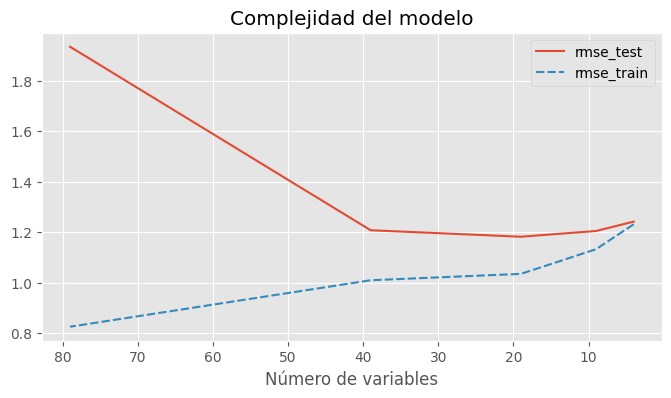

In [43]:
plt.style.use('ggplot')

plt.figure(figsize=(8,4))
ax = sns.lineplot(data=df_scores.set_index("n_variables"))
ax.invert_xaxis()
ax.set_title("Complejidad del modelo");
ax.set(xlabel="Número de variables");
#sns.lineplot(data=df_scores, x="n_variables", y ="rmse_train")


Las variables seleccionadas para entrenar los modelos son_
- TEMPERATURE
- rezago_1
- prec_rezago_8	
- temp_rezago_12